## Retenção de clientes
A partir do dataset `sample_event_table.csv` com registo de atividades de clientes, pretende-se apresentar uma visualização na forma de **cohort**, sobre o nível de retenção de clientes.

Uma amostra dos dados é apresentada em seguida.

In [151]:
import pandas as pd
from operator import attrgetter

df = pd.read_csv('../data/sample_event_table.csv')
df.head(10)

,customer_id,event_date,event_name
0,2,2014-01-20 00:00:00,engagement_event
1,2,2014-01-24 00:00:00,engagement_event
2,2,2014-01-26 00:00:00,engagement_event
3,3,2014-01-08 00:00:00,engagement_event
4,3,2014-01-20 00:00:00,engagement_event
5,3,2014-01-25 00:00:00,engagement_event
6,4,2014-01-16 00:00:00,engagement_event
7,4,2014-01-23 00:00:00,engagement_event
8,4,2014-01-26 00:00:00,engagement_event
9,5,2014-01-25 00:00:00,engagement_event


Para analisar o nível de retenção é estudada a relação entre o primeiro registo (cohort) e o número de períodos (meses) desde o primeiro registo.

Note que:

- Os clientes são identificados pelo mês em que fizeram o primeiro registo, sendo este mês designado de cohort.
- Os clientes interagem com o sistema ao longo do tempo desde que fizeram o seu primeiro registo e a análise faz a contagem desses registos, ao logo dos meses.
- Referência: https://www.kaggle.com/code/ahmetokanyilmaz/cohort-analysis-with-python

In [152]:
# convert event_date to datetime in format  format='%m/%d/%Y %H:%M'
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%m/%d/%Y %H:%M')
df.head()

,customer_id,event_date,event_name
0,2,01/20/2014 00:00,engagement_event
1,2,01/24/2014 00:00,engagement_event
2,2,01/26/2014 00:00,engagement_event
3,3,01/08/2014 00:00,engagement_event
4,3,01/20/2014 00:00,engagement_event


In [153]:
df.event_date = pd.to_datetime(df.event_date, format='%m/%d/%Y %H:%M')

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  11968 non-null  int64         
 1   event_date   11968 non-null  datetime64[ns]
 2   event_name   11968 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 280.6+ KB


In [155]:
df.head()

,customer_id,event_date,event_name
0,2,2014-01-20,engagement_event
1,2,2014-01-24,engagement_event
2,2,2014-01-26,engagement_event
3,3,2014-01-08,engagement_event
4,3,2014-01-20,engagement_event


Precisamos de  `payment period`, `cohort group` e `cohort period/index`

1. Criando `cohort` e `order_month`

In [156]:
df['order_month'] = df.event_date.dt.to_period('M')
df.head()

,customer_id,event_date,event_name,order_month
0,2,2014-01-20,engagement_event,2014-01
1,2,2014-01-24,engagement_event,2014-01
2,2,2014-01-26,engagement_event,2014-01
3,3,2014-01-08,engagement_event,2014-01
4,3,2014-01-20,engagement_event,2014-01


In [157]:
df['cohort'] = df.groupby('customer_id')['event_date'].transform('min').dt.to_period('M')
df.head()

,customer_id,event_date,event_name,order_month,cohort
0,2,2014-01-20,engagement_event,2014-01,2014-01
1,2,2014-01-24,engagement_event,2014-01,2014-01
2,2,2014-01-26,engagement_event,2014-01,2014-01
3,3,2014-01-08,engagement_event,2014-01,2014-01
4,3,2014-01-20,engagement_event,2014-01,2014-01


Agregando os dados por `cohort` e `order_month` e contando o número de clientes únicos por `cohort` e `order_month`.

In [158]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort.head()

,cohort,order_month,n_customers
0,2014-01,2014-01,78
1,2014-01,2014-02,75
2,2014-01,2014-03,72
3,2014-01,2014-04,70
4,2014-01,2014-05,69


In [159]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2014-01,2014-01,78,0
1,2014-01,2014-02,75,1
2,2014-01,2014-03,72,2
3,2014-01,2014-04,70,3
4,2014-01,2014-05,69,4


Pivoteando cohort_group

In [160]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9
cohort,,,,,,,,,,
2014-01,78.0,75.0,72.0,70.0,69.0,67.0,66.0,66.0,65.0,64.0
2014-02,88.0,86.0,82.0,78.0,77.0,76.0,73.0,72.0,70.0,NaN
2014-03,103.0,103.0,98.0,94.0,92.0,90.0,86.0,82.0,NaN,NaN
2014-04,107.0,106.0,102.0,99.0,97.0,92.0,90.0,NaN,NaN,NaN
2014-05,114.0,112.0,105.0,98.0,97.0,96.0,NaN,NaN,NaN,NaN
2014-06,128.0,122.0,119.0,115.0,110.0,NaN,NaN,NaN,NaN,NaN
2014-07,136.0,129.0,122.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,149.0,145.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,158.0,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plotando o heatmap

<Axes: xlabel='period_number', ylabel='cohort'>

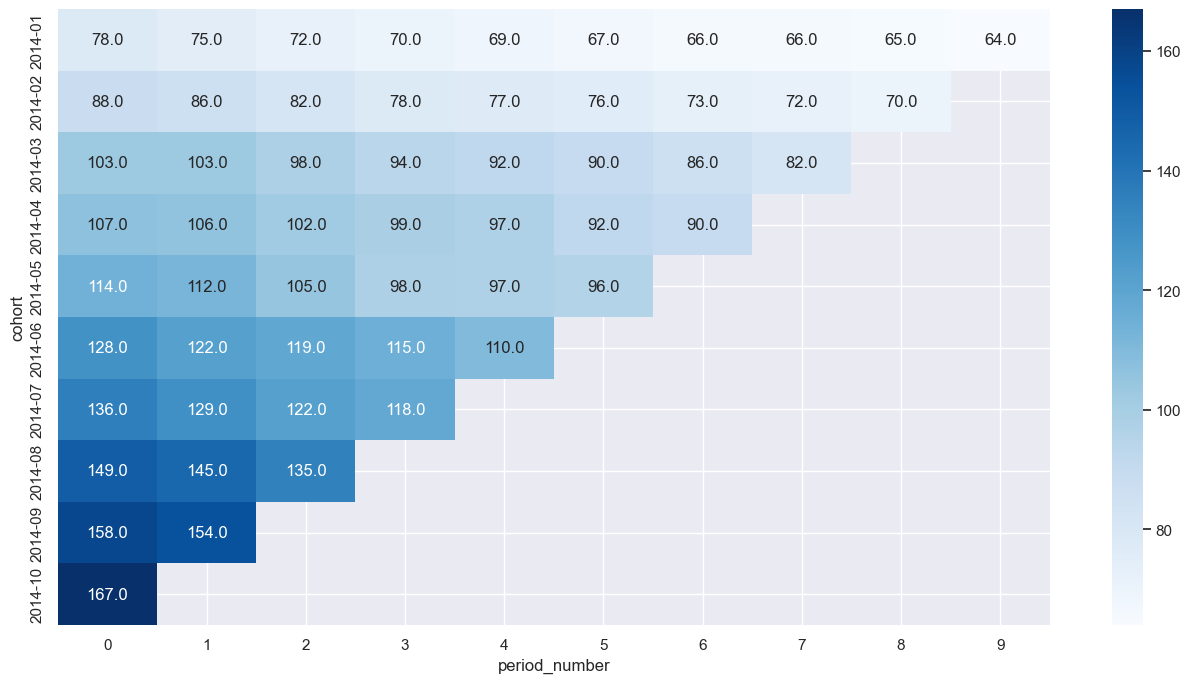

In [161]:
import seaborn as sns

#heatmap de cohort_pivot
sns.set(style='white')
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(cohort_pivot, annot=True, fmt='.1f', cmap='Blues')